# 微积分基础 - 理解梯度下降

## 学习目标
- 理解导数的几何意义
- 掌握偏导数和梯度
- 理解链式法则（反向传播的基础）
- 实现梯度下降算法
- 理解学习率的作用

---

## 为什么机器学习需要微积分？

### 核心问题：如何训练模型？

**训练 = 找到最好的参数，使损失函数最小**

- **导数** 告诉我们：函数在某点的变化率（斜率）
- **梯度** 告诉我们：多变量函数在某点的最快上升方向
- **梯度下降** 利用梯度：沿着梯度的反方向走，找到最小值

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 配置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(42)
print('✓ 库导入成功')

✓ 库导入成功


## 1. 导数 (Derivative)

### 什么是导数？

**导数 = 函数在某点的斜率 = 变化率**

$$f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$$

### 几何意义
- 导数 > 0：函数在上升
- 导数 = 0：函数达到极值点（或鞍点）
- 导数 < 0：函数在下降

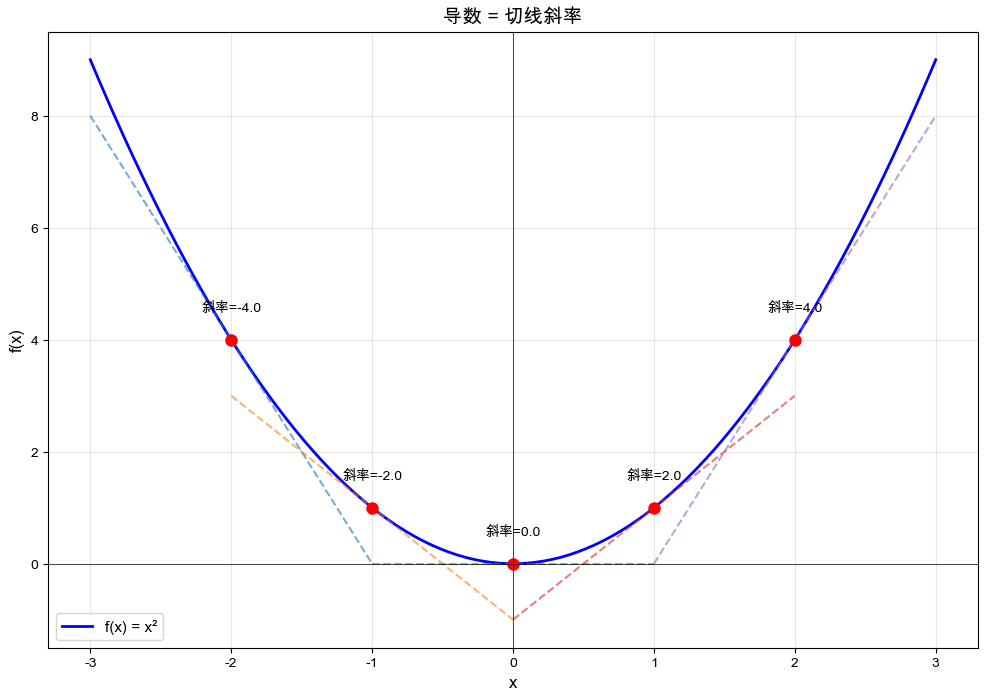

In [2]:
# 可视化导数
def f(x):
    """示例函数 f(x) = x^2"""
    return x**2

def df(x):
    """导数 f'(x) = 2x"""
    return 2*x

# 绘图
x = np.linspace(-3, 3, 100)
y = f(x)

# 选择几个点画切线
points = [-2, -1, 0, 1, 2]

plt.figure(figsize=(12, 8))
plt.plot(x, y, 'b-', linewidth=2, label='f(x) = x²')

for point in points:
    # 计算切线
    slope = df(point)
    y_point = f(point)
    # 切线方程: y - y0 = m(x - x0)
    x_tangent = np.linspace(point-1, point+1, 10)
    y_tangent = slope * (x_tangent - point) + y_point
    
    plt.plot(x_tangent, y_tangent, '--', alpha=0.6, linewidth=1.5)
    plt.plot(point, y_point, 'ro', markersize=8)
    plt.text(point, y_point + 0.5, f"斜率={slope:.1f}", ha='center', fontsize=10)

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.title('导数 = 切线斜率', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.show()

### 数值计算导数

In [3]:
def numerical_derivative(f, x, h=1e-5):
    """
    用数值方法计算导数
    f'(x) ≈ [f(x+h) - f(x)] / h
    """
    return (f(x + h) - f(x)) / h

# 测试
x = 2
analytical = df(x)  # 解析解: 2x = 4
numerical = numerical_derivative(f, x)  # 数值解

print(f'在x={x}处的导数:')
print(f'  解析解: {analytical}')
print(f'  数值解: {numerical:.6f}')
print(f'  误差: {abs(analytical - numerical):.8f}')

在x=2处的导数:
  解析解: 4
  数值解: 4.000010
  误差: 0.00001000


### 常见函数的导数

| 函数 | 导数 |
|------|------|
| $f(x) = c$ | $f'(x) = 0$ |
| $f(x) = x$ | $f'(x) = 1$ |
| $f(x) = x^n$ | $f'(x) = nx^{n-1}$ |
| $f(x) = e^x$ | $f'(x) = e^x$ |
| $f(x) = \ln(x)$ | $f'(x) = 1/x$ |
| $f(x) = \sin(x)$ | $f'(x) = \cos(x)$ |
| $f(x) = \cos(x)$ | $f'(x) = -\sin(x)$ |

## 2. 梯度 (Gradient)

### 多变量函数的导数

对于函数 $f(x, y)$，有两个**偏导数**：
- $\frac{\partial f}{\partial x}$：y不变时，f对x的变化率
- $\frac{\partial f}{\partial y}$：x不变时，f对y的变化率

**梯度** = 所有偏导数组成的向量：
$$\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}$$

### 梯度的几何意义
- **方向**：函数增长最快的方向
- **大小**：增长的速率

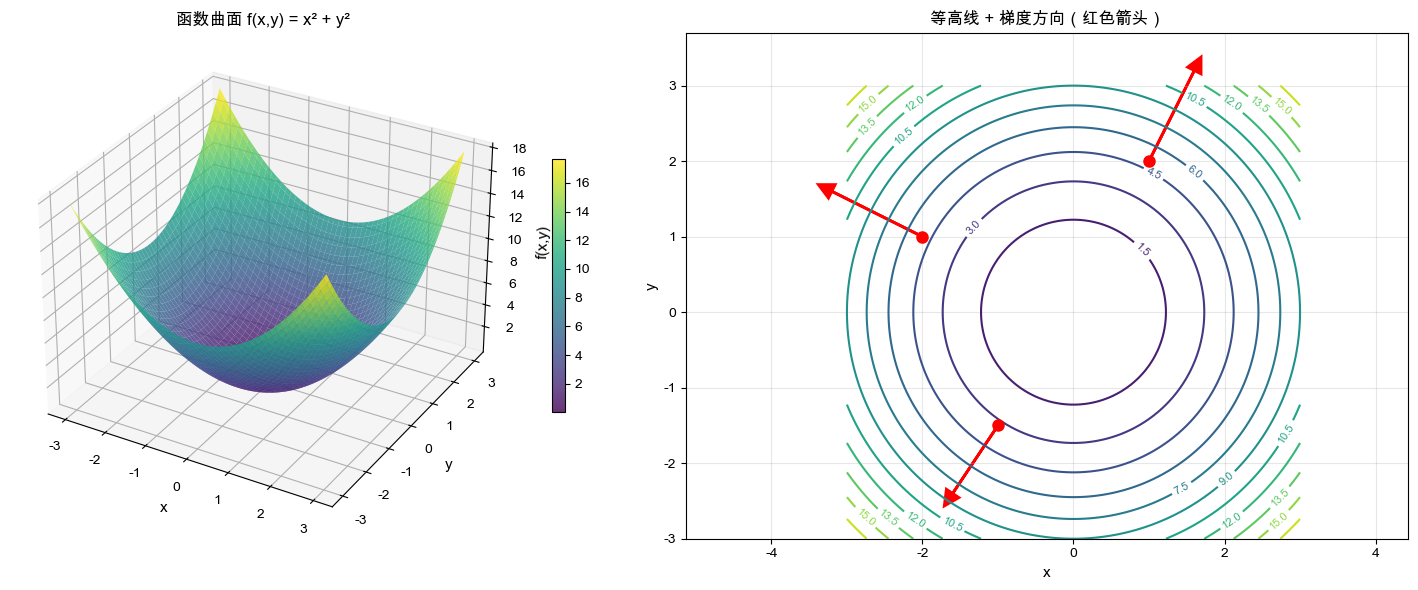

观察：梯度总是垂直于等高线，指向函数增长最快的方向


In [4]:
# 二维函数示例
def f_2d(x, y):
    """f(x,y) = x^2 + y^2"""
    return x**2 + y**2

def gradient_f_2d(x, y):
    """梯度 ∇f = [2x, 2y]"""
    return np.array([2*x, 2*y])

# 创建网格
x_range = np.linspace(-3, 3, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = f_2d(X, Y)

# 3D可视化
fig = plt.figure(figsize=(15, 6))

# 左图：3D曲面
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8)
ax1.set_xlabel('x', fontsize=11)
ax1.set_ylabel('y', fontsize=11)
ax1.set_zlabel('f(x,y)', fontsize=11)
ax1.set_title('函数曲面 f(x,y) = x² + y²', fontsize=12)
fig.colorbar(surf, ax=ax1, shrink=0.5)

# 右图：等高线 + 梯度
ax2 = fig.add_subplot(122)
contour = ax2.contour(X, Y, Z, levels=15, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)

# 绘制梯度向量
points = [(-2, 1), (1, 2), (-1, -1.5)]
for px, py in points:
    grad = gradient_f_2d(px, py)
    ax2.arrow(px, py, grad[0]*0.3, grad[1]*0.3, 
             head_width=0.2, head_length=0.2, 
             fc='red', ec='red', linewidth=2)
    ax2.plot(px, py, 'ro', markersize=8)

ax2.set_xlabel('x', fontsize=11)
ax2.set_ylabel('y', fontsize=11)
ax2.set_title('等高线 + 梯度方向（红色箭头）', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

print('观察：梯度总是垂直于等高线，指向函数增长最快的方向')

## 3. 链式法则 (Chain Rule)

### 为什么重要？
**神经网络的反向传播就是链式法则！**

### 定义
如果 $y = f(u)$ 且 $u = g(x)$，则：
$$\frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx}$$

### 示例
$y = (x^2 + 1)^3$

令 $u = x^2 + 1$，则 $y = u^3$

$$\frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx} = 3u^2 \cdot 2x = 6x(x^2+1)^2$$

In [5]:
# 链式法则示例
def composite_function(x):
    """复合函数 y = (x^2 + 1)^3"""
    return (x**2 + 1)**3

def derivative_composite(x):
    """导数 dy/dx = 6x(x^2 + 1)^2"""
    return 6 * x * (x**2 + 1)**2

# 验证
x_test = 2
analytical = derivative_composite(x_test)
numerical = numerical_derivative(composite_function, x_test)

print(f'在x={x_test}处:')
print(f'  解析导数: {analytical}')
print(f'  数值导数: {numerical:.4f}')
print('✓ 链式法则验证成功！')

在x=2处:
  解析导数: 300
  数值导数: 300.0032
✓ 链式法则验证成功！


### 📌 ML应用：反向传播

简单神经网络：$y = f(w_2 \cdot f(w_1 \cdot x))$

计算损失对$w_1$的导数：
$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial h} \cdot \frac{\partial h}{\partial w_1}$$

这就是反向传播！

In [6]:
# 简单的反向传播示例
class SimpleNeuron:
    """单个神经元的前向和反向传播"""
    
    def __init__(self):
        self.w = 0.5  # 权重
        self.b = 0.0  # 偏置
    
    def sigmoid(self, x):
        """激活函数"""
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """sigmoid的导数"""
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, x):
        """前向传播"""
        self.x = x
        self.z = self.w * x + self.b  # 线性变换
        self.a = self.sigmoid(self.z)  # 激活
        return self.a
    
    def backward(self, grad_output):
        """反向传播（链式法则）"""
        # grad_output = dL/da
        # 需要计算 dL/dw 和 dL/db
        
        # dL/dz = dL/da * da/dz (链式法则)
        grad_z = grad_output * self.sigmoid_derivative(self.z)
        
        # dL/dw = dL/dz * dz/dw = dL/dz * x
        grad_w = grad_z * self.x
        
        # dL/db = dL/dz * dz/db = dL/dz * 1
        grad_b = grad_z
        
        return grad_w, grad_b

# 测试
neuron = SimpleNeuron()
x = 1.0
output = neuron.forward(x)
grad_w, grad_b = neuron.backward(grad_output=1.0)

print('前向传播:')
print(f'  输入x = {x}')
print(f'  输出a = {output:.4f}')
print('\n反向传播（链式法则）:')
print(f'  dL/dw = {grad_w:.4f}')
print(f'  dL/db = {grad_b:.4f}')

前向传播:
  输入x = 1.0
  输出a = 0.6225

反向传播（链式法则）:
  dL/dw = 0.2350
  dL/db = 0.2350


## 4. 梯度下降 (Gradient Descent)

### 核心思想
要找到函数的最小值，沿着**梯度的反方向**移动！

### 算法
1. 随机初始化参数 $\theta$
2. 计算梯度 $\nabla L(\theta)$
3. 更新参数：$\theta = \theta - \alpha \nabla L(\theta)$
4. 重复步骤2-3，直到收敛

其中 $\alpha$ 是**学习率**（learning rate）

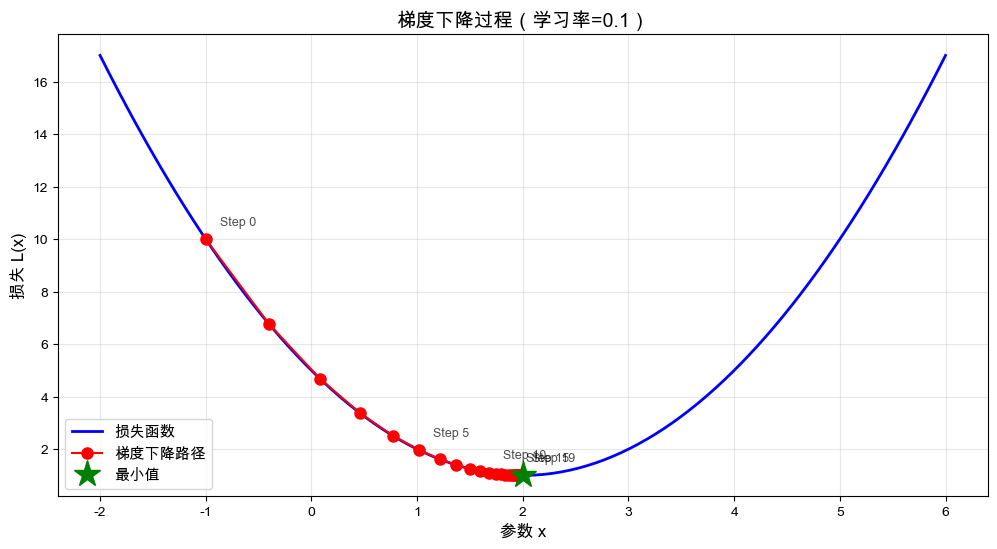

初始值: -1.0000
最终值: 1.9654
真实最小值: 2.0000


In [7]:
# 1D梯度下降可视化
def loss_function(x):
    """损失函数 L(x) = (x-2)^2 + 1"""
    return (x - 2)**2 + 1

def gradient_loss(x):
    """梯度 dL/dx = 2(x-2)"""
    return 2 * (x - 2)

# 梯度下降
def gradient_descent_1d(start_x, learning_rate, n_iterations):
    """
    1D梯度下降
    """
    x = start_x
    history = [x]
    
    for i in range(n_iterations):
        grad = gradient_loss(x)
        x = x - learning_rate * grad  # 更新规则
        history.append(x)
    
    return np.array(history)

# 运行梯度下降
start = -1.0
lr = 0.1
iters = 20
history = gradient_descent_1d(start, lr, iters)

# 可视化
x_range = np.linspace(-2, 6, 100)
y_range = loss_function(x_range)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_range, 'b-', linewidth=2, label='损失函数')
plt.plot(history, loss_function(history), 'ro-', markersize=8, label='梯度下降路径')
plt.plot(2, loss_function(2), 'g*', markersize=20, label='最小值')

# 标注步骤
for i in [0, 5, 10, 15, 19]:
    plt.annotate(f'Step {i}', 
                xy=(history[i], loss_function(history[i])),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, alpha=0.7)

plt.xlabel('参数 x', fontsize=12)
plt.ylabel('损失 L(x)', fontsize=12)
plt.title(f'梯度下降过程（学习率={lr}）', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f'初始值: {history[0]:.4f}')
print(f'最终值: {history[-1]:.4f}')
print(f'真实最小值: 2.0000')

### 学习率的影响

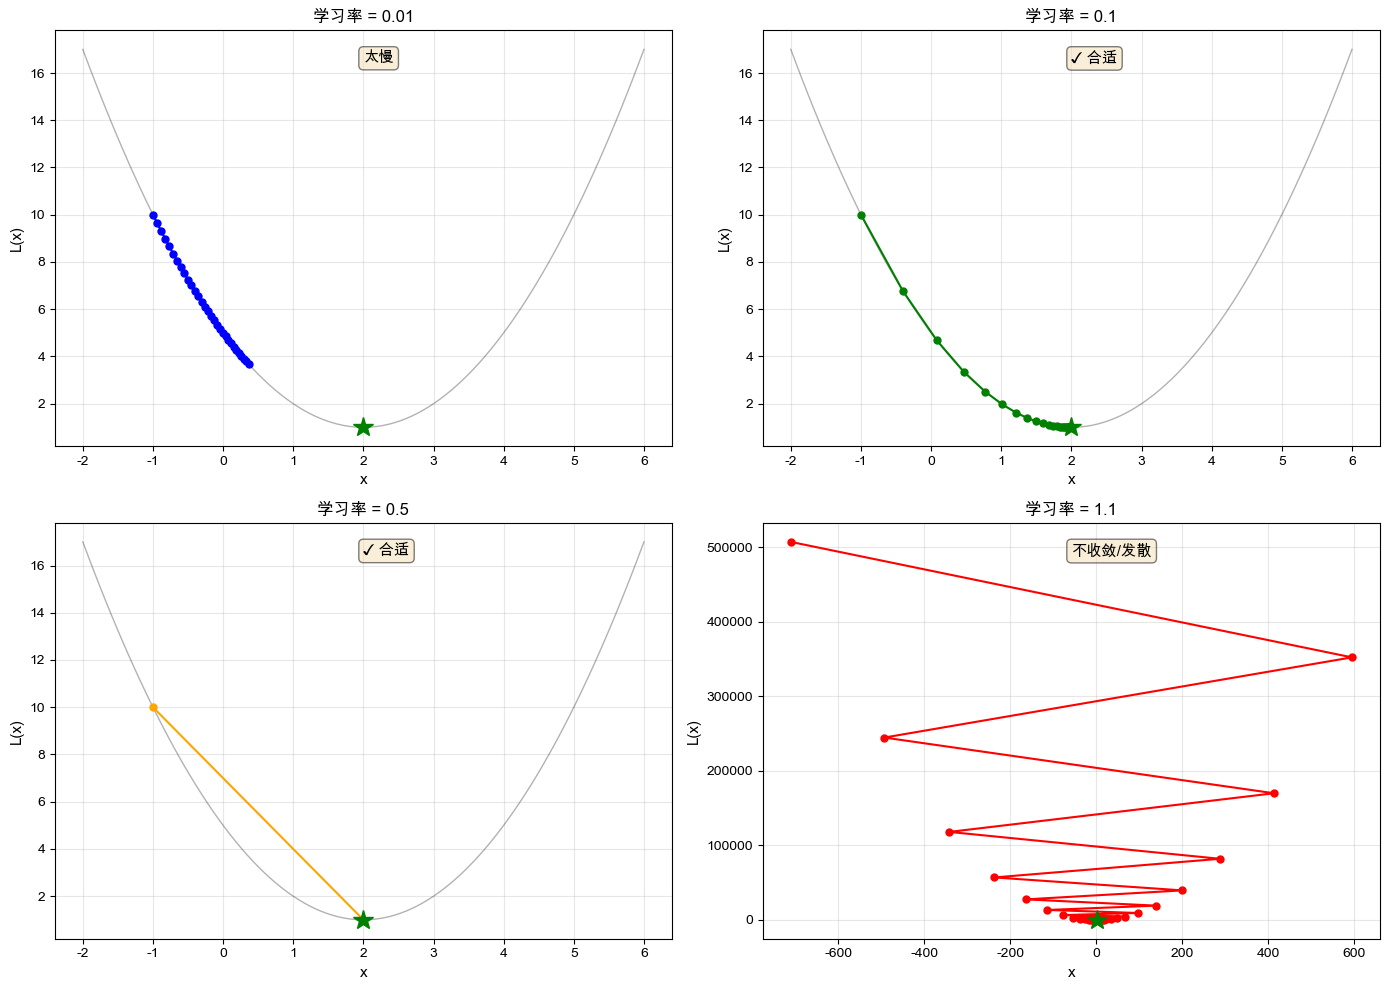

学习率选择：
  太小 → 收敛慢
  太大 → 震荡或发散
  合适 → 快速收敛


In [8]:
# 对比不同学习率
learning_rates = [0.01, 0.1, 0.5, 1.1]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(14, 10))

for i, (lr, color) in enumerate(zip(learning_rates, colors), 1):
    plt.subplot(2, 2, i)
    
    # 运行梯度下降
    history = gradient_descent_1d(-1.0, lr, 30)
    
    # 绘制
    x_range = np.linspace(-2, 6, 100)
    y_range = loss_function(x_range)
    
    plt.plot(x_range, y_range, 'k-', linewidth=1, alpha=0.3)
    plt.plot(history, loss_function(history), 'o-', 
            color=color, markersize=5, linewidth=1.5)
    plt.plot(2, 1, 'g*', markersize=15)
    
    plt.xlabel('x', fontsize=11)
    plt.ylabel('L(x)', fontsize=11)
    plt.title(f'学习率 = {lr}', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 判断收敛情况
    if lr < 0.1:
        status = '太慢'
    elif lr > 1.0:
        status = '不收敛/发散'
    else:
        status = '✓ 合适'
    
    plt.text(0.5, 0.95, status, 
            transform=plt.gca().transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print('学习率选择：')
print('  太小 → 收敛慢')
print('  太大 → 震荡或发散')
print('  合适 → 快速收敛')

### 📌 ML应用：训练线性回归

In [9]:
# 生成数据
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# 梯度下降训练线性回归
class LinearRegressionGD:
    def __init__(self, learning_rate=0.1, n_iterations=100):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.w = None
        self.b = None
        self.loss_history = []
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        
        # 初始化参数
        self.w = 0.0
        self.b = 0.0
        
        for i in range(self.n_iterations):
            # 前向传播
            y_pred = self.w * X + self.b
            
            # 计算损失（MSE）
            loss = np.mean((y - y_pred)**2)
            self.loss_history.append(loss)
            
            # 计算梯度
            dw = -(2/n_samples) * np.sum(X * (y - y_pred))
            db = -(2/n_samples) * np.sum(y - y_pred)
            
            # 更新参数（梯度下降）
            self.w -= self.lr * dw
            self.b -= self.lr * db
            
            if (i+1) % 20 == 0:
                print(f'Iteration {i+1}: Loss={loss:.4f}, w={self.w:.4f}, b={self.b:.4f}')
        
        return self
    
    def predict(self, X):
        return self.w * X + self.b

# 训练
model = LinearRegressionGD(learning_rate=0.1, n_iterations=100)
model.fit(X, y)

print(f'\n最终参数:')
print(f'  w = {model.w:.4f} (真实值: 3.0)')
print(f'  b = {model.b:.4f} (真实值: 4.0)')

Iteration 20: Loss=0.8870, w=3.2100, b=3.7167
Iteration 40: Loss=0.8268, w=2.9907, b=3.9653
Iteration 60: Loss=0.8117, w=2.8807, b=4.0899
Iteration 80: Loss=0.8079, w=2.8255, b=4.1523
Iteration 100: Loss=0.8069, w=2.7979, b=4.1836

最终参数:
  w = 2.7979 (真实值: 3.0)
  b = 4.1836 (真实值: 4.0)


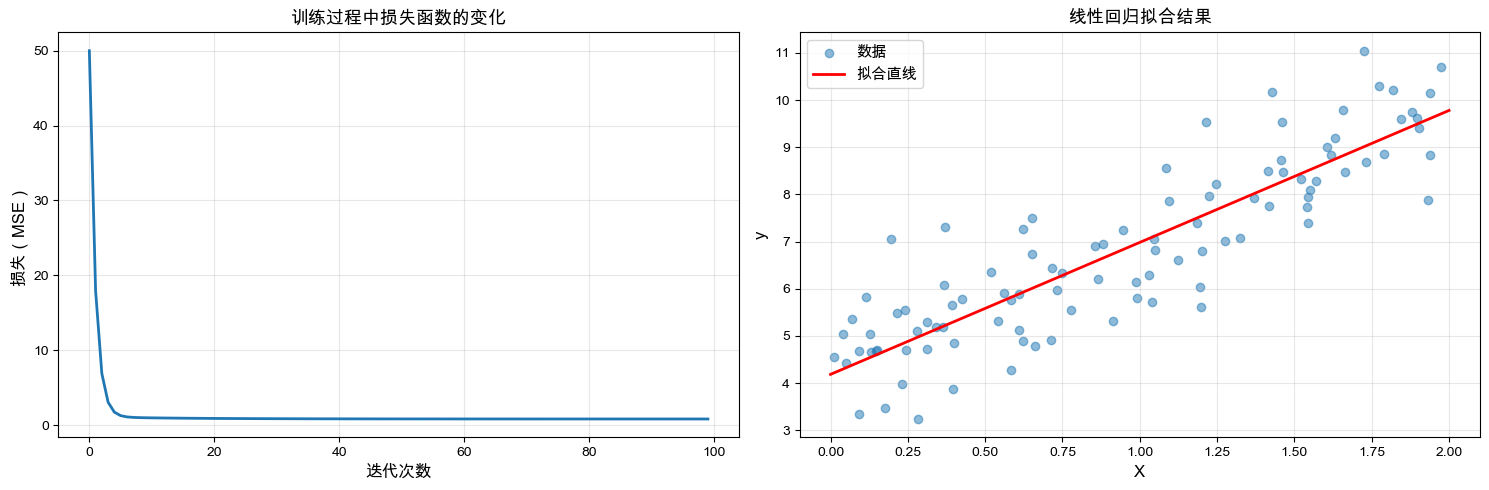

In [10]:
# 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 左图：损失下降
axes[0].plot(model.loss_history, linewidth=2)
axes[0].set_xlabel('迭代次数', fontsize=12)
axes[0].set_ylabel('损失（MSE）', fontsize=12)
axes[0].set_title('训练过程中损失函数的变化', fontsize=13)
axes[0].grid(True, alpha=0.3)

# 右图：拟合结果
axes[1].scatter(X, y, alpha=0.5, label='数据')
X_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_pred = model.predict(X_test)
axes[1].plot(X_test, y_pred, 'r-', linewidth=2, label='拟合直线')
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('线性回归拟合结果', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 2D梯度下降可视化

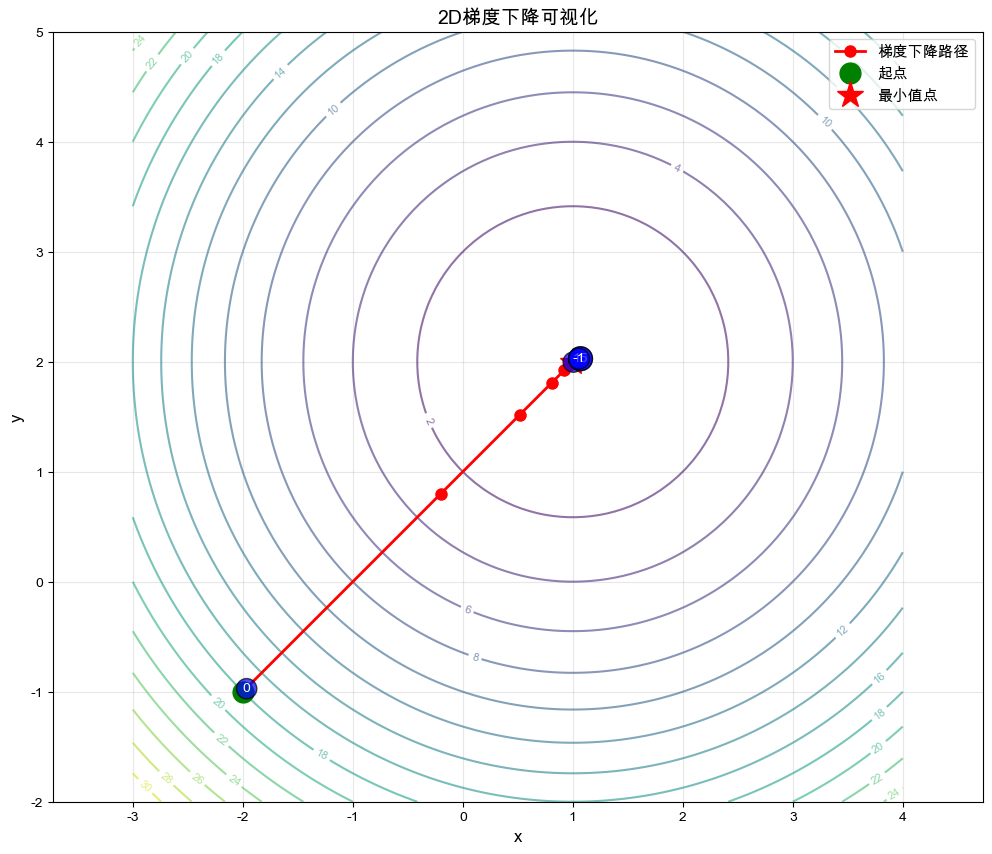

起点: (-2.00, -1.00)
终点: (1.0000, 2.0000)
真实最小值: (1.0, 2.0)


In [11]:
# 2D梯度下降
def loss_2d(x, y):
    """2D损失函数"""
    return (x - 1)**2 + (y - 2)**2

def gradient_2d(x, y):
    """梯度"""
    dx = 2 * (x - 1)
    dy = 2 * (y - 2)
    return np.array([dx, dy])

def gradient_descent_2d(start, learning_rate, n_iterations):
    """2D梯度下降"""
    point = np.array(start)
    history = [point.copy()]
    
    for i in range(n_iterations):
        grad = gradient_2d(point[0], point[1])
        point = point - learning_rate * grad
        history.append(point.copy())
    
    return np.array(history)

# 运行梯度下降
start_point = [-2, -1]
history = gradient_descent_2d(start_point, learning_rate=0.3, n_iterations=30)

# 可视化
x_range = np.linspace(-3, 4, 100)
y_range = np.linspace(-2, 5, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = loss_2d(X, Y)

plt.figure(figsize=(12, 10))

# 等高线
contour = plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
plt.clabel(contour, inline=True, fontsize=8)

# 梯度下降路径
plt.plot(history[:, 0], history[:, 1], 'ro-', 
        markersize=8, linewidth=2, label='梯度下降路径')
plt.plot(history[0, 0], history[0, 1], 'go', 
        markersize=15, label='起点')
plt.plot(1, 2, 'r*', markersize=20, label='最小值点')

# 标注关键步骤
for i in [0, 5, 10, 15, -1]:
    plt.annotate(f'{i}', 
                xy=(history[i, 0], history[i, 1]),
                fontsize=10, color='white',
                bbox=dict(boxstyle='circle', facecolor='blue', alpha=0.7))

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('2D梯度下降可视化', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print(f'起点: ({history[0, 0]:.2f}, {history[0, 1]:.2f})')
print(f'终点: ({history[-1, 0]:.4f}, {history[-1, 1]:.4f})')
print(f'真实最小值: (1.0, 2.0)')

## 6. 实战练习

### 练习1：实现数值微分

In [12]:
# TODO: 实现数值梯度计算
def numerical_gradient(f, x, h=1e-5):
    """
    计算多变量函数的数值梯度
    f: 函数
    x: 点（numpy数组）
    返回: 梯度向量
    """
    # 你的代码...
    pass

# 测试
def test_f(x):
    return x[0]**2 + x[1]**2

# 在点(1, 2)处应该得到梯度[2, 4]

### 练习2：带Momentum的梯度下降

In [13]:
# TODO: 实现带动量的梯度下降
def gradient_descent_momentum(start, learning_rate, momentum, n_iterations):
    """
    带动量的梯度下降
    v = momentum * v - learning_rate * gradient
    x = x + v
    """
    # 你的代码...
    pass

### 练习3：实现Sigmoid梯度

In [14]:
# TODO: 推导并实现sigmoid函数的导数
# sigmoid(x) = 1 / (1 + e^(-x))
# 提示: sigmoid'(x) = sigmoid(x) * (1 - sigmoid(x))

def sigmoid(x):
    # 你的代码...
    pass

def sigmoid_derivative(x):
    # 你的代码...
    pass

## 7. 总结

### 核心知识点
- ✅ 导数 = 函数的斜率 = 变化率
- ✅ 梯度 = 多变量函数的导数向量
- ✅ 链式法则 = 复合函数求导 = 反向传播
- ✅ 梯度下降 = 沿梯度反方向更新参数
- ✅ 学习率 = 控制步长的大小

### 机器学习应用

| 微积分概念 | ML应用 |
|-----------|--------|
| 导数 | 参数对损失的影响 |
| 梯度 | 多参数优化方向 |
| 链式法则 | 反向传播算法 |
| 梯度下降 | 训练算法 |
| 学习率 | 超参数调优 |

### 关键公式

**梯度下降更新规则：**
$$\theta_{\text{new}} = \theta_{\text{old}} - \alpha \nabla L(\theta)$$

**链式法则：**
$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial w_1}$$

### 重要概念
1. **梯度指向函数增长最快的方向**
2. **梯度下降沿反方向走，找最小值**
3. **学习率太大会震荡，太小收敛慢**
4. **反向传播 = 链式法则的应用**

---

### 下一步
学习**概率统计基础**，理解模型的不确定性和预测！